In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### SWS

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.24, Prune Accuracy: 96.51, Sparsity: 97.67
Epoch: 20. Test Accuracy: 97.66, Prune Accuracy: 97.31, Sparsity: 97.68
Epoch: 30. Test Accuracy: 97.68, Prune Accuracy: 97.53, Sparsity: 97.68
Epoch: 40. Test Accuracy: 97.68, Prune Accuracy: 97.62, Sparsity: 97.70
Epoch: 50. Test Accuracy: 97.87, Prune Accuracy: 97.51, Sparsity: 97.75
Retrain Test: 97.87, Prune Test: 97.51, Prune Sparsity: 97.75


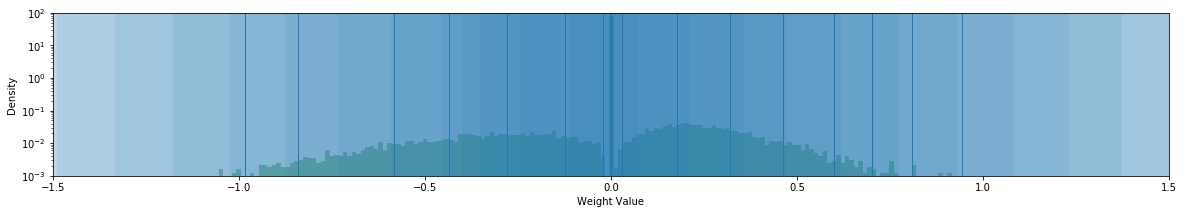

In [3]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "./files")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.08, Prune Accuracy: 96.31, Sparsity: 97.71
Epoch: 20. Test Accuracy: 97.57, Prune Accuracy: 97.08, Sparsity: 97.72
Epoch: 30. Test Accuracy: 97.75, Prune Accuracy: 97.41, Sparsity: 97.70
Epoch: 40. Test Accuracy: 97.75, Prune Accuracy: 97.57, Sparsity: 97.76
Epoch: 50. Test Accuracy: 97.75, Prune Accuracy: 97.50, Sparsity: 97.78
Retrain Test: 97.75, Prune Test: 97.50, Prune Sparsity: 97.78


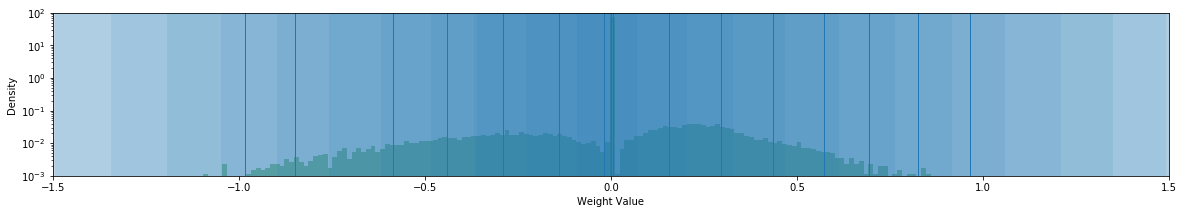

In [4]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', True, "./files")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### SWS + KD

#### CE

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.33, Prune Accuracy: 97.91, Sparsity: 69.46
Epoch: 20. Test Accuracy: 98.01, Prune Accuracy: 95.71, Sparsity: 94.50
Epoch: 30. Test Accuracy: 98.16, Prune Accuracy: 97.04, Sparsity: 96.90
Epoch: 40. Test Accuracy: 98.09, Prune Accuracy: 97.46, Sparsity: 96.90
Epoch: 50. Test Accuracy: 98.03, Prune Accuracy: 97.66, Sparsity: 96.91
Retrain Test: 98.03, Prune Test: 97.66, Prune Sparsity: 96.91


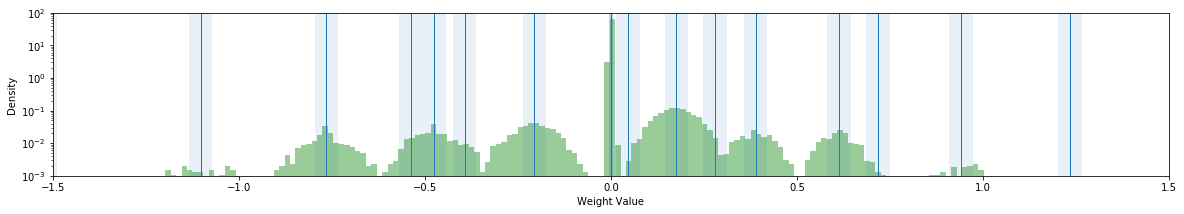

In [6]:
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.39, Prune Accuracy: 91.25, Sparsity: 71.76
Epoch: 20. Test Accuracy: 98.03, Prune Accuracy: 92.80, Sparsity: 97.18
Epoch: 30. Test Accuracy: 97.98, Prune Accuracy: 95.00, Sparsity: 97.35
Epoch: 40. Test Accuracy: 98.14, Prune Accuracy: 95.73, Sparsity: 97.35
Epoch: 50. Test Accuracy: 98.01, Prune Accuracy: 95.96, Sparsity: 97.36
Retrain Test: 98.01, Prune Test: 95.96, Prune Sparsity: 97.36


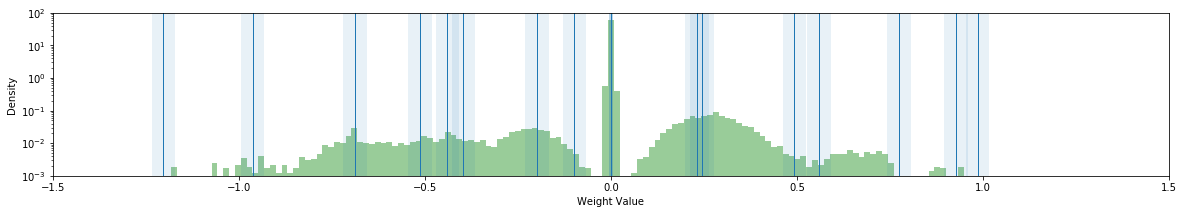

In [7]:
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.40, Prune Accuracy: 98.04, Sparsity: 68.52
Epoch: 20. Test Accuracy: 98.33, Prune Accuracy: 96.57, Sparsity: 82.73
Epoch: 30. Test Accuracy: 98.04, Prune Accuracy: 94.63, Sparsity: 97.11
Epoch: 40. Test Accuracy: 98.14, Prune Accuracy: 96.13, Sparsity: 97.13
Epoch: 50. Test Accuracy: 98.11, Prune Accuracy: 96.36, Sparsity: 97.15
Retrain Test: 98.11, Prune Test: 96.36, Prune Sparsity: 97.15


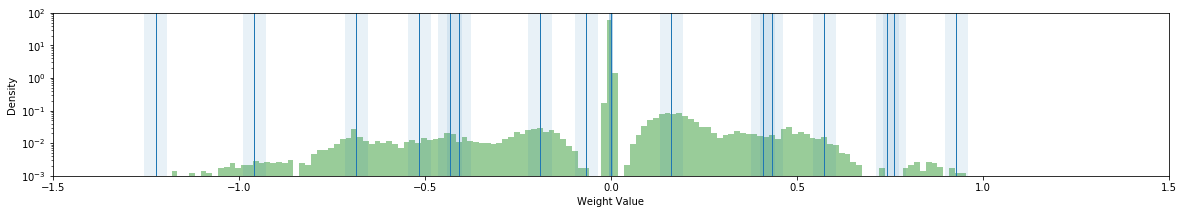

In [8]:
#reduce tau 1e-5 -> 0.8e-5
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 0.8e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.37, Prune Accuracy: 98.07, Sparsity: 66.17
Epoch: 20. Test Accuracy: 98.32, Prune Accuracy: 94.74, Sparsity: 77.03
Epoch: 30. Test Accuracy: 98.09, Prune Accuracy: 93.38, Sparsity: 97.12
Epoch: 40. Test Accuracy: 98.17, Prune Accuracy: 95.72, Sparsity: 97.13
Epoch: 50. Test Accuracy: 98.13, Prune Accuracy: 96.38, Sparsity: 97.14
Retrain Test: 98.13, Prune Test: 96.38, Prune Sparsity: 97.14


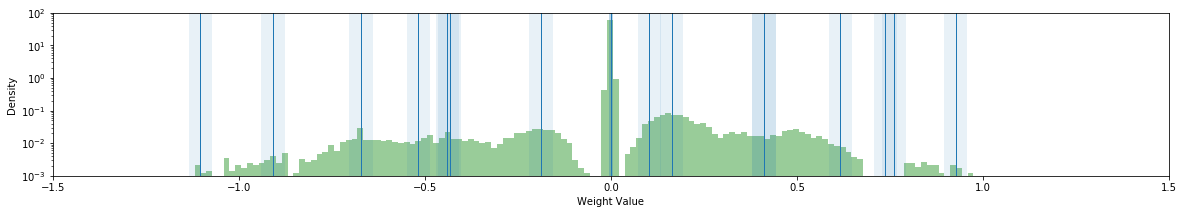

In [9]:
#reduce tau 1e-5 -> 0.8e-5
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 0.7e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.38, Prune Accuracy: 97.67, Sparsity: 63.61
Epoch: 20. Test Accuracy: 98.13, Prune Accuracy: 90.47, Sparsity: 84.79
Epoch: 30. Test Accuracy: 97.80, Prune Accuracy: 96.16, Sparsity: 92.70
Epoch: 40. Test Accuracy: 97.85, Prune Accuracy: 96.55, Sparsity: 93.42
Epoch: 50. Test Accuracy: 97.86, Prune Accuracy: 96.84, Sparsity: 93.88
Retrain Test: 97.86, Prune Test: 96.84, Prune Sparsity: 93.88


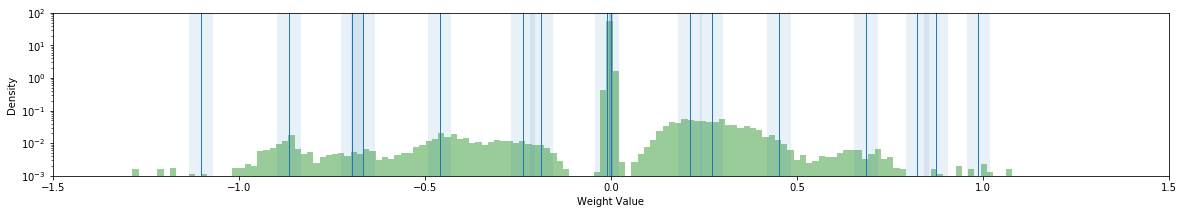

In [25]:
#LR 1e-6 to 1e-5, 5e-5 to 1e-5
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.35, Prune Accuracy: 88.50, Sparsity: 73.58
Epoch: 20. Test Accuracy: 98.23, Prune Accuracy: 92.85, Sparsity: 88.04
Epoch: 30. Test Accuracy: 98.01, Prune Accuracy: 93.06, Sparsity: 92.33
Epoch: 40. Test Accuracy: 98.11, Prune Accuracy: 89.66, Sparsity: 77.26
Epoch: 50. Test Accuracy: 98.17, Prune Accuracy: 91.46, Sparsity: 84.50
Retrain Test: 98.17, Prune Test: 91.46, Prune Sparsity: 84.50


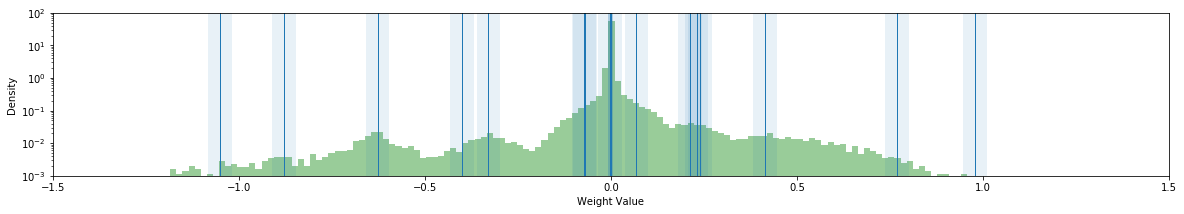

In [27]:
#LR 1e-5 to 1e-4, mean back to 5e-5
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.32, Prune Accuracy: 96.25, Sparsity: 73.79
Epoch: 20. Test Accuracy: 97.67, Prune Accuracy: 93.68, Sparsity: 97.53
Epoch: 30. Test Accuracy: 97.94, Prune Accuracy: 96.21, Sparsity: 97.56
Epoch: 40. Test Accuracy: 97.98, Prune Accuracy: 96.54, Sparsity: 97.57
Epoch: 50. Test Accuracy: 98.01, Prune Accuracy: 96.64, Sparsity: 97.57
Epoch: 60. Test Accuracy: 98.01, Prune Accuracy: 96.82, Sparsity: 97.57
Epoch: 70. Test Accuracy: 97.93, Prune Accuracy: 96.94, Sparsity: 97.58
Epoch: 80. Test Accuracy: 98.03, Prune Accuracy: 96.98, Sparsity: 97.58
Retrain Test: 98.03, Prune Test: 96.98, Prune Sparsity: 97.58


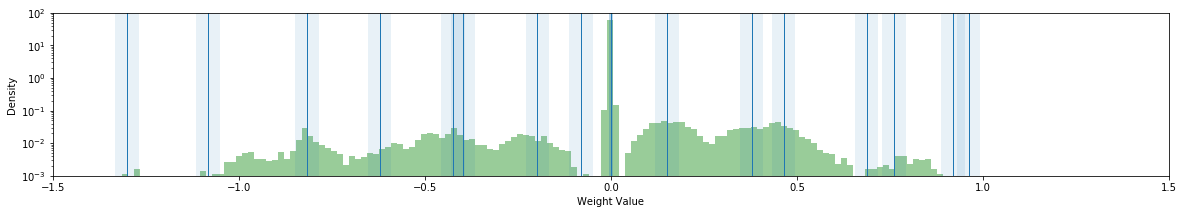

In [31]:
#LR back to normal, increase tau
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1.3e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.21, Prune Accuracy: 95.80, Sparsity: 76.42
Epoch: 20. Test Accuracy: 97.85, Prune Accuracy: 94.33, Sparsity: 97.50
Epoch: 30. Test Accuracy: 97.76, Prune Accuracy: 96.60, Sparsity: 97.53
Epoch: 40. Test Accuracy: 97.96, Prune Accuracy: 96.83, Sparsity: 97.53
Epoch: 50. Test Accuracy: 98.01, Prune Accuracy: 97.06, Sparsity: 97.54
Epoch: 60. Test Accuracy: 98.03, Prune Accuracy: 96.88, Sparsity: 97.54
Epoch: 70. Test Accuracy: 97.92, Prune Accuracy: 97.08, Sparsity: 97.55
Epoch: 80. Test Accuracy: 97.86, Prune Accuracy: 97.08, Sparsity: 97.55
Epoch: 90. Test Accuracy: 97.83, Prune Accuracy: 97.06, Sparsity: 97.55
Epoch: 100. Test Accuracy: 97.95, Prune Accuracy: 97.07, Sparsity: 97.55
Retrain Test: 97.95, Prune Test: 97.07, Prune Sparsity: 97.55


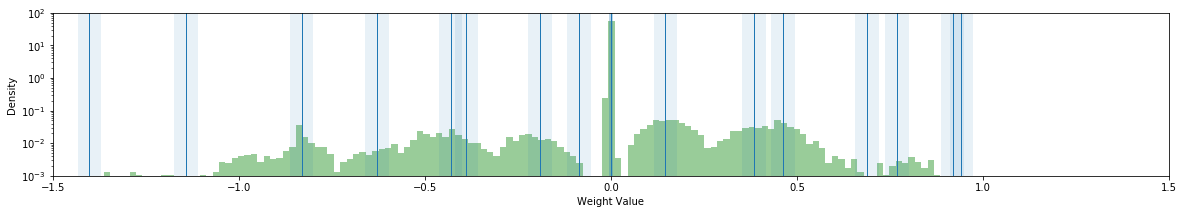

In [32]:
#tau -> 1.5
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1.5e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

In [36]:
res.keys()

dict_keys(['sparsity', 'prune_acc', 'complexity_loss', 'temp', 'val_acc', 'cm', 'zvar', 'mean', 'gmp_stddev', 'var', 'mixtures', 'data_size', 'val_loss', 'test_loss', 'epochs', 'test_acc', 'gmp_mixprop', 'train_acc', 'scale', 'init_weights', 'final_weights', 'train_loss', 'zmean', 'gmp_means', 'prune_weights', 'tau'])

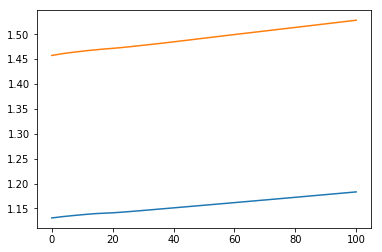

In [37]:
plt.plot(res['scale'])

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.00, Prune Accuracy: 90.07, Sparsity: 97.58
Epoch: 20. Test Accuracy: 97.57, Prune Accuracy: 89.91, Sparsity: 98.11
Epoch: 30. Test Accuracy: 97.65, Prune Accuracy: 94.12, Sparsity: 98.12
Epoch: 40. Test Accuracy: 97.75, Prune Accuracy: 94.59, Sparsity: 98.12
Epoch: 50. Test Accuracy: 97.83, Prune Accuracy: 95.00, Sparsity: 98.13
Epoch: 60. Test Accuracy: 97.84, Prune Accuracy: 95.10, Sparsity: 98.13
Epoch: 70. Test Accuracy: 97.91, Prune Accuracy: 95.34, Sparsity: 98.13
Epoch: 80. Test Accuracy: 97.92, Prune Accuracy: 95.44, Sparsity: 98.13
Epoch: 90. Test Accuracy: 97.94, Prune Accuracy: 95.39, Sparsity: 98.13
Retrain Test: 97.94, Prune Test: 95.39, Prune Sparsity: 98.13


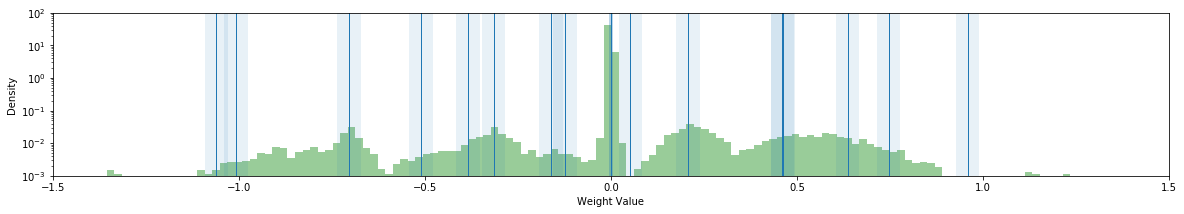

In [39]:
#tau -> 2, lr = 5e-5, lr ->0 at 70th epoch
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 2e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.04, Prune Accuracy: 93.87, Sparsity: 96.78
Epoch: 20. Test Accuracy: 97.47, Prune Accuracy: 94.92, Sparsity: 98.03
Epoch: 30. Test Accuracy: 97.75, Prune Accuracy: 95.96, Sparsity: 98.03
Epoch: 40. Test Accuracy: 97.77, Prune Accuracy: 96.00, Sparsity: 98.03
Epoch: 50. Test Accuracy: 97.78, Prune Accuracy: 95.97, Sparsity: 98.03
Retrain Test: 97.78, Prune Test: 95.97, Prune Sparsity: 98.03


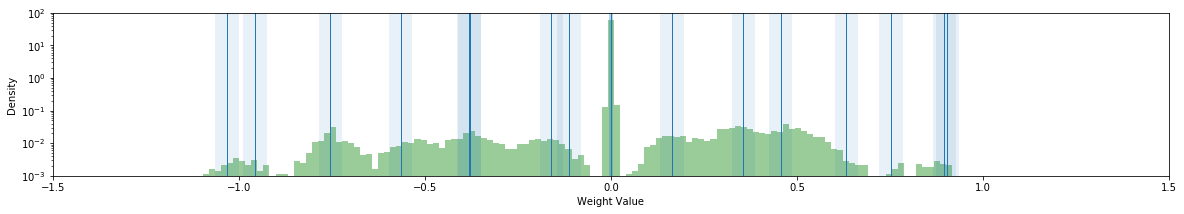

In [45]:
#
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 2e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

#### MSE